# Chapter 4, Exercise 2: Full MNIST

> Complete all the steps in this chaper using the full MNIST dataset, not just 3s and 7s.

I'm going to follow most of the steps...I'm going to skip the parts about solving the linear equation.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42) # Life, the Universe, and Everything

from fastai.vision.all import *

The [fast.ai datasets](https://course.fast.ai/datasets) include MNIST, not just the sample -- so let's do that.

In [2]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/home/aardvark/.fastai/data/mnist_png/training'),Path('/home/aardvark/.fastai/data/mnist_png/testing')]

Let's look at a random 8:

In [3]:
eights = (path / 'training/8').ls().sorted()
im8_path = eights[1]
im8 = Image.open(im8_path)
im8

Let's compare tensors and arrays:

In [4]:
array(im8)[5:15, 5:15]

array([[ 58, 125, 245, 187, 254, 255, 214, 125, 225, 157],
       [118, 253, 253, 253, 253, 253, 253, 253, 253, 253],
       [242, 253, 253, 253, 253, 253, 253, 253, 253, 253],
       [194, 253, 253, 253, 253, 108,  19,  56,  48, 140],
       [ 73, 198, 253, 253, 253, 245, 188,  71,  76, 201],
       [  0,  14, 152, 197, 253, 253, 253, 244, 246, 253],
       [  0,   0,   0,  15, 152, 240, 253, 253, 253, 253],
       [  0,   0,   0,   0,   0, 215, 253, 253, 253, 253],
       [  0,   0,   0,   0,  26, 226, 253, 233,  81, 148],
       [  0,   0,   0,  26, 200, 253, 233,  68,   0,   0]], dtype=uint8)

In [5]:
tensor(im8)[5:15, 5:15]

tensor([[ 58, 125, 245, 187, 254, 255, 214, 125, 225, 157],
        [118, 253, 253, 253, 253, 253, 253, 253, 253, 253],
        [242, 253, 253, 253, 253, 253, 253, 253, 253, 253],
        [194, 253, 253, 253, 253, 108,  19,  56,  48, 140],
        [ 73, 198, 253, 253, 253, 245, 188,  71,  76, 201],
        [  0,  14, 152, 197, 253, 253, 253, 244, 246, 253],
        [  0,   0,   0,  15, 152, 240, 253, 253, 253, 253],
        [  0,   0,   0,   0,   0, 215, 253, 253, 253, 253],
        [  0,   0,   0,   0,  26, 226, 253, 233,  81, 148],
        [  0,   0,   0,  26, 200, 253, 233,  68,   0,   0]], dtype=torch.uint8)

Now let's convert the tensor version of im8 to a dataframe, because Pandas has display _down_.

In [6]:
im8_t = tensor(im8)
df = pd.DataFrame(im8_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,58,125,245,187,254,255,214,125,225,157,35,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,118,253,253,253,253,253,253,253,253,253,249,136,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,242,253,253,253,253,253,253,253,253,253,253,251,137,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,194,253,253,253,253,108,19,56,48,140,253,253,250,235,235,225,46,0,0,0,0,0,0
9,0,0,0,0,0,73,198,253,253,253,245,188,71,76,201,253,253,253,253,253,195,68,0,0,0,0,0,0


Now, let's get the average of each of the numbers.  Remember:  that means stacking them, then taking the mean.

In [24]:
ndata = list(range(10)) # This will hold all the everythings
ndata

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

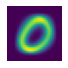

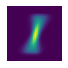

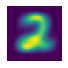

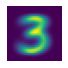

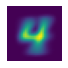

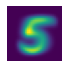

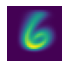

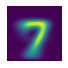

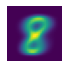

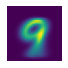

In [28]:
for i in range(10):
    paths = (path / 'training' / '{}'.format(i)).ls().sorted()
    tensor_indiv = [tensor(Image.open(p)) for p in paths]
    ndata[i] = {}
    ndata[i]['tensor_stack'] = torch.stack(tensor_indiv).float() / 255.0
    ndata[i]['tensor_mean'] = ndata[i]['tensor_stack'].mean(0)
    show_image(ndata[i]['tensor_mean'])

Okay, not bad progress for one night!  Next up: pg 140, figuring out distance from the average.